**Installation**

In [1]:
!pip install wurlitzer
%load_ext wurlitzer

**Importation**

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from numba import cuda
import numba
import math
import time

1 -- Lire L'image :
  dans cette etape je vaie lire l'image pop.jpg

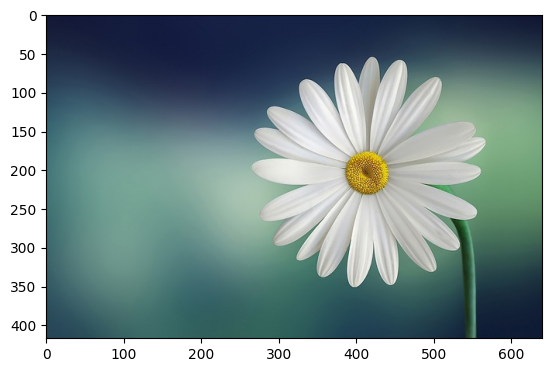

In [4]:

# image_path = "./ap1.jpg"
image_path = "./pop.jpg"

# lire l'image par Pillow
image = Image.open(image_path)

# voire l'image
plt.imshow(image)


convirtir l'image a un tableau 2xD

In [5]:
# image ----> NumPy array
image_array = np.array(image)
# image_array

1 - MATRICE DE GAUSSIAN


In [6]:
kernel_size = 27
sigma = 12

gaussian = np.zeros((kernel_size, kernel_size))

@cuda.jit
def gk_blur(sigma, kernel_size, kernel):
    m = kernel_size // 2
    n = kernel_size // 2

    x, y = cuda.grid(2)

    if x < kernel_size and y < kernel_size:

        exponent = -((x - m)**2 + (y - n)**2) / (2 * sigma**2)
        kernel[x, y] =  np.int32( ( 1 / (2 * math.pi * sigma**2) ) * math.exp(exponent) * 1000 )



# Define the block dimensions
block_dim = (4, 4)

# Calculate the grid dimensions using math.ceil
grid_dim_x = math.ceil(kernel_size / block_dim[0])
grid_dim_y = math.ceil(kernel_size / block_dim[1])
grid_dim = (grid_dim_x, grid_dim_y)

d_gaussian = cuda.to_device(gaussian)

# Launch the kernel with the updated grid dimensions
gk_blur[grid_dim, block_dim](sigma, kernel_size, d_gaussian)
cuda.synchronize()  # Wait for the kernel to finish before transferring data back

gaussian = d_gaussian.copy_to_host()
# print(gaussian)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


calculer la somme de matrice gaussian

In [7]:
somme_gaussian = np.sum(gaussian)

In [8]:
@cuda.jit
def process_image_cuda(image_array, gaussainGrid, result_array, directions, kenrelsize, sommeG):
    pos_i, pos_j = cuda.grid(2)
    tmpR = 0
    tmpG = 0
    tmpB = 0

    pas = int(kenrelsize // 2)

    if pos_i < image_array.shape[0] and pos_j < image_array.shape[1]:
        R = image_array[pos_i, pos_j][0] # R
        G = image_array[pos_i, pos_j][1] # G
        B = image_array[pos_i, pos_j][2] # B

        for ni, nj in directions:
            new_i, new_j = pos_i + ni, pos_j + nj
            if 0 <= new_i and 0<=new_j and new_i < image_array.shape[0] and new_j < image_array.shape[1]:
                 tmpR += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][0]
                 tmpG += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][1]
                 tmpB += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][2]
            else:
                  tmpR += gaussainGrid[ni + pas, nj + pas] * R
                  tmpG += gaussainGrid[ni + pas, nj + pas] * G
                  tmpB += gaussainGrid[ni + pas, nj + pas] * B

        result_array[pos_i, pos_j][0] = tmpR // sommeG # 256
        result_array[pos_i, pos_j][1] = tmpG // sommeG # 256
        result_array[pos_i, pos_j][2] = tmpB // sommeG # 256


extraire les position des voisins

In [9]:
def get_neighbors(size):
    N = size // 2

    neighbors = []
    for i in range(-N, N + 1):
        for j in range(-N, N + 1):
                neighbors.append((i, j))

    return neighbors

# directions = [(0,0),
#           (0, 1), (0, -1), (1, 0), (-1, 0),
#           (1, 1), (-1, 1), (1, -1), (-1, -1),
#           (0, 2), (0, -2), (2, 0), (-2, 0),
#           (1, 2), (1, -2), (2, 1), (-2, 1),
#           (-1, 2), (-1, -2), (2, -1), (-2, -1),
#         ]
directions = get_neighbors(kernel_size)
print(directions)

[(-13, -13), (-13, -12), (-13, -11), (-13, -10), (-13, -9), (-13, -8), (-13, -7), (-13, -6), (-13, -5), (-13, -4), (-13, -3), (-13, -2), (-13, -1), (-13, 0), (-13, 1), (-13, 2), (-13, 3), (-13, 4), (-13, 5), (-13, 6), (-13, 7), (-13, 8), (-13, 9), (-13, 10), (-13, 11), (-13, 12), (-13, 13), (-12, -13), (-12, -12), (-12, -11), (-12, -10), (-12, -9), (-12, -8), (-12, -7), (-12, -6), (-12, -5), (-12, -4), (-12, -3), (-12, -2), (-12, -1), (-12, 0), (-12, 1), (-12, 2), (-12, 3), (-12, 4), (-12, 5), (-12, 6), (-12, 7), (-12, 8), (-12, 9), (-12, 10), (-12, 11), (-12, 12), (-12, 13), (-11, -13), (-11, -12), (-11, -11), (-11, -10), (-11, -9), (-11, -8), (-11, -7), (-11, -6), (-11, -5), (-11, -4), (-11, -3), (-11, -2), (-11, -1), (-11, 0), (-11, 1), (-11, 2), (-11, 3), (-11, 4), (-11, 5), (-11, 6), (-11, 7), (-11, 8), (-11, 9), (-11, 10), (-11, 11), (-11, 12), (-11, 13), (-10, -13), (-10, -12), (-10, -11), (-10, -10), (-10, -9), (-10, -8), (-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (

effectue un benchmark en mesurant le temps d'exécution moyen de l'algorithme de traitement d'image, comme ce que nous avons fait dans le 2 TP


In [14]:
# Fonction pour effectuer le benchmark
def benchmark_thread_block_sizes(image_array, sizes):
    temps_execution = []

    for size in sizes:
        debut = time.time()

        # Effectuer le traitement d'image avec la taille de bloc de threads spécifiée
        threadsparbloc = (size, size)
        grilles_x = math.ceil(image_array.shape[0] / threadsparbloc[0])
        grilles_y = math.ceil(image_array.shape[1] / threadsparbloc[1])
        grilles = (grilles_x, grilles_y)

        d_input = cuda.to_device(image_array)
        d_output = cuda.to_device(np.zeros_like(image_array, dtype=np.float32))
        d_gaussian = cuda.to_device(gaussian)
        d_directions = cuda.to_device(directions)

        process_image_cuda[grilles, threadsparbloc](d_input,d_gaussian, d_output, d_directions, kernel_size, somme_gaussian)

        d_output.copy_to_host(np.zeros_like(image_array, dtype=np.float32))

        fin = time.time()

        # Calculer le temps d'exécution
        temps_execution.append(fin - debut)

    return temps_execution

Appel de fonction

In [16]:
# Spécifier les tailles de bloc de threads à tester
tailles_bloc_threads = [8, 10, 12, 16]

# Effectuer le benchmark
temps_execution_moyens = benchmark_thread_block_sizes(image_array, tailles_bloc_threads)

# Afficher les résultats
for taille, temps_moyen in zip(tailles_bloc_threads, temps_execution_moyens):
    print(f"Taille du bloc de threads : {taille}x{taille}, Temps moyen d'exécution : {temps_moyen:.6f} secondes")

Taille du bloc de threads : 8x8, Temps moyen d'exécution : 0.036277 secondes
Taille du bloc de threads : 10x10, Temps moyen d'exécution : 0.041852 secondes
Taille du bloc de threads : 12x12, Temps moyen d'exécution : 0.037181 secondes
Taille du bloc de threads : 16x16, Temps moyen d'exécution : 0.034756 secondes
